# Predicting Future Stock Prices using 10-k filing financial indicators
This project will attempt to predict the performance of stocks given financial data commonly found in the 10K filings. This solution will be both classification, ie should you buy this stock or not, as well as a regression analysis of the actual future value of the stock. Companies spend countless dollars and resources trying to gain an edge on Wall Street and this solution could provide value to companies and employees in finance across the world.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow import keras

My Data source: https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018 contains 200+ financial indicators from the year 2018, that are commonly found in the 10-K filings each publicly traded company releases yearly, for a plethora of US stocks (4k stocks are listed in each dataset). The dataset was built leveraging Financial Modeling Prep API and pandas_datareader.

In [2]:
data_18 = pd.read_csv('2018_Financial_Data.csv')
data_17 = pd.read_csv('2017_Financial_Data.csv')
data_16 = pd.read_csv('2016_Financial_Data.csv')
data_15 = pd.read_csv('2015_Financial_Data.csv')
data_14 = pd.read_csv('2014_Financial_Data.csv')


data_18['Year'] = data_18.apply(lambda x: 2018, axis=1)
data_17['Year'] = data_17.apply(lambda x: 2017, axis=1)
data_16['Year'] = data_16.apply(lambda x: 2016, axis=1)
data_15['Year'] = data_15.apply(lambda x: 2015, axis=1)
data_14['Year'] = data_14.apply(lambda x: 2014, axis=1)


data_18.head()

,Unnamed: 0,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,2019 PRICE VAR [%],Class,Year
0,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,...,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,32.794573,1,2018
1,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,...,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,40.588068,1,2018
2,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,...,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,30.295514,1,2018
3,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,...,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942,Technology,64.213737,1,2018
4,GE,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,4.071100e+10,-1.455700e+10,5.059000e+09,...,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308,Industrials,44.757840,1,2018


In [3]:
#Adding Dataframes together
data_df = pd.DataFrame()
data_df = pd.concat([data_18,data_17,data_16,data_15,data_14],axis=0,ignore_index=False)
    
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 3807
Columns: 230 entries, Unnamed: 0 to 2015 PRICE VAR [%]
dtypes: float64(226), int64(2), object(2)
memory usage: 38.9+ MB


In [4]:
#Renaming Stock Name column
data_df = data_df.rename(columns ={'Unnamed: 0':'Stock'})

In [5]:
#Delete columns if at least a quarter of the total information is null
for column in data_df.columns:
    if data_df[column].isnull().sum() > 5500:
        data_df = data_df.drop([column],axis=1)
        
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22077 entries, 0 to 3807
Columns: 189 entries, Stock to Year
dtypes: float64(185), int64(2), object(2)
memory usage: 32.0+ MB


In [6]:
#Delete rows if at least a quarter of the total information is null

data_df = data_df[data_df.isnull().sum(axis=1)<47]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677 entries, 0 to 3807
Columns: 189 entries, Stock to Year
dtypes: float64(185), int64(2), object(2)
memory usage: 28.5+ MB


In [7]:
#What are the sectors in the dataset and the amount of stocks for each?
data_df['Sector'].value_counts()

Financial Services        3232
Healthcare                3205
Technology                3030
Industrials               2647
Consumer Cyclical         2335
Basic Materials           1279
Real Estate               1136
Energy                    1099
Consumer Defensive         856
Utilities                  485
Communication Services     373
Name: Sector, dtype: int64

In [8]:
Sector_df = data_df.groupby(['Sector','Class'],as_index=False)['Stock'].count()

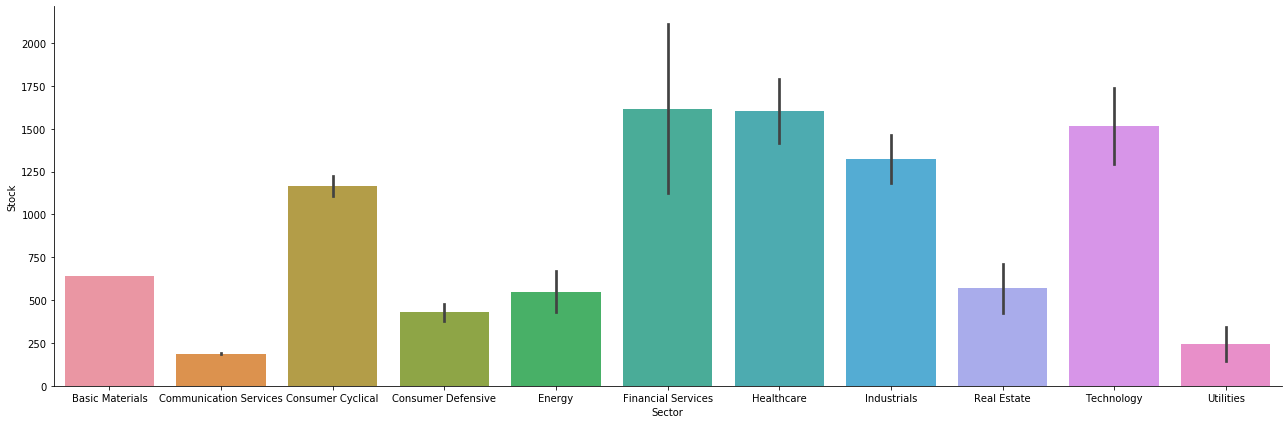

In [9]:
#Whatis the distribution of stock by industry?
sns.catplot(x='Sector',y='Stock', kind ='bar', height = 6, aspect = 3, data=Sector_df);

The stocks are fairly spread out by industry, with Healthcare, Technology and Financial Services the most represented in the dataset.

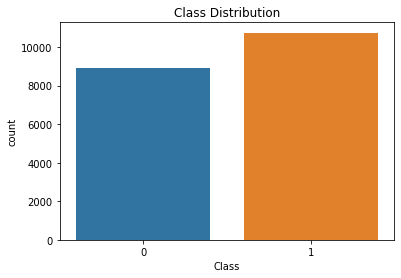

In [10]:
#Is our class variable balanced?
sns.countplot(data_df['Class'])
plt.title('Class Distribution');

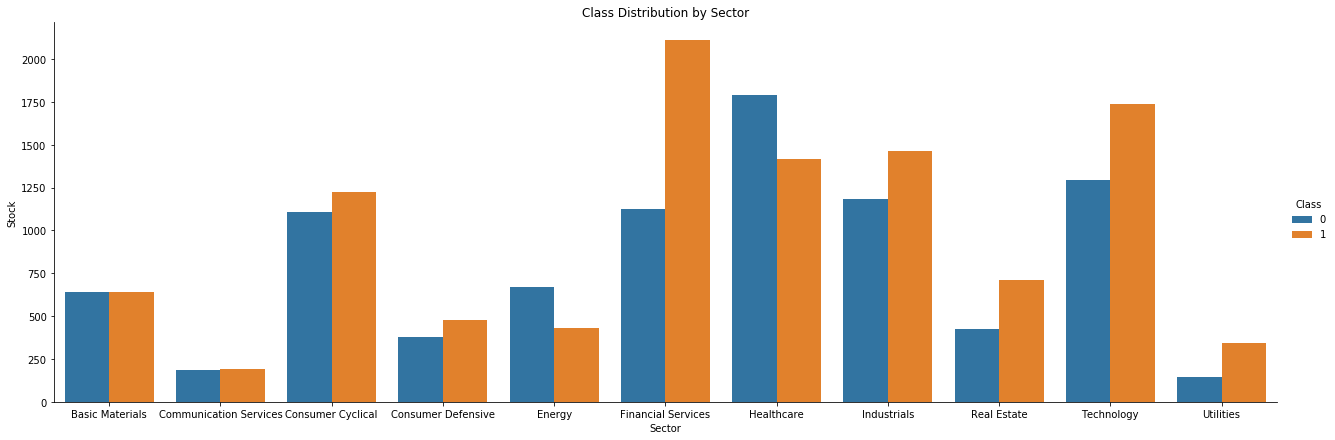

In [11]:
#Which industries have more suggested buys?
sns.catplot(x="Sector", y="Stock", hue="Class", kind="bar", height = 6, aspect = 3,data=Sector_df)
plt.title('Class Distribution by Sector');

It's been a good 5 years for most industries. Most sectors have more suggested buys (Class 1, orange columns), versus do not buy (Class 0, blue columns) for their stocks.

In [12]:
#Use Decision Tree Regressor Imputation to replace the null values
import time
from fancyimpute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
#Time the imputation algorithm
start = time.time()
MICE_imputer = IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt', 
                                                random_state=0))
df_numeric = data_df.select_dtypes(include=[np.float])
data_MICE = df_numeric.copy(deep=True)
data_MICE.iloc[:, :] = MICE_imputer.fit_transform(data_MICE)
end = time.time()
print('Runtime is {} and the shape of the output is {}.'.format((end - start),data_MICE.shape))

Using TensorFlow backend.


Runtime is 106.04478120803833 and the shape of the output is (19677, 185).


In [13]:
#Add target
data_MICE['Class'] = data_df['Class']
#Rename
data_df = data_MICE
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19677 entries, 0 to 3807
Columns: 186 entries, Revenue to Class
dtypes: float64(185), int64(1)
memory usage: 28.1 MB


In [14]:
#Double check no null values left
for column in data_df.columns:
    if data_df[column].isnull().sum()>0:
        print(column)
    else :
        continue
print('No null values left!')


No null values left!


No null values left in our dataset and we can proceed to looking for outliers.

In [15]:
#Identify outliers
Q1 = data_df.quantile(0.25)
Q3 = data_df.quantile(0.75)
IQR = Q3 - Q1

((data_df < (Q1 - 1.5 * IQR)) | (data_df > (Q3 + 1.5 * IQR))).sum()

Revenue                        2834
Revenue Growth                 2883
Cost of Revenue                2901
Gross Profit                   2716
R&D Expenses                   3495
                               ... 
Book Value per Share Growth    3620
Debt Growth                    4070
R&D Expense Growth             7216
SG&A Expenses Growth           2300
Class                             0
Length: 186, dtype: int64

In [16]:
from scipy.stats import mstats

#Winsorize the data to correct outliers that are part of the 95%
def WinsorizeStats(data):
    out = mstats.winsorize(data, limits=[0.05, 0.05])
    
    return out

data_df = pd.DataFrame(data=WinsorizeStats(data_df), columns=data_MICE.columns)

((data_df < (Q1 - 1.5 * IQR)) | (data_df > (Q3 + 1.5 * IQR))).sum()

Revenue                           0
Revenue Growth                 2883
Cost of Revenue                   0
Gross Profit                      0
R&D Expenses                   3492
                               ... 
Book Value per Share Growth    3620
Debt Growth                    4070
R&D Expense Growth             7216
SG&A Expenses Growth           2300
Class                             0
Length: 186, dtype: int64

I decided to use winsorization to cap the dataset at 95% due to the large amount of outliers present in the dataset. 

In [17]:
#Identify features that are highly correlated
correlated_features = set()
correlation_matrix = data_df.corr()

for i in range(len(correlation_matrix.columns)):
     for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(len(correlated_features))


55


In [18]:
#Drop the highly correlated features
data_df = data_df.drop(correlated_features,axis=1)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19677 entries, 0 to 19676
Columns: 131 entries, Revenue to Class
dtypes: float64(131)
memory usage: 19.7 MB


In [19]:
print('6')

6


In [20]:
#Identify best features using Recursive Feature Elimination
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
data1_df = data_df.copy()
X = data1_df.drop('Class', axis=1)
target = data1_df['Class']

rfc = RandomForestClassifier(random_state=101,criterion='entropy')
rfecv = RFECV(estimator=rfc, step=2, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, target)
print('The model is suggesting using {} features'.format(rfecv.n_features_))

The model is suggesting using 124 features


Used Recursive Feature Elimination to figure out which models to proceed forward with in the modeling phase.

In [21]:
#Removing features that have not been suggested by the RFECV
cols = data_df.columns
rankings_df = pd.DataFrame(list(zip(cols,rfecv.ranking_)),columns=['Column','Rank'])
rank1_df = rankings_df[rankings_df['Rank']==1]

features = rank1_df['Column'].tolist()
features.append('Class')

for col in data_df.columns:
    if col not in features:
        data_df = data_df.drop(col,axis=1)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19677 entries, 0 to 19676
Columns: 125 entries, Revenue to Class
dtypes: float64(125)
memory usage: 18.8 MB


In [22]:
#Split X and Y
target = data_df['Class']
x = data_df.drop(['Class'],axis=1)

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15741, 124) (15741,)
(3936, 124) (3936,)


In [23]:
#Random Forest Classification
clf = RandomForestClassifier(n_estimators = 1100,random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
clf_predict = clf.predict(X_test)

In [25]:
# #Random Forest Results
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
clf_cv_score = cross_val_score(clf, x, target, cv=10)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, clf_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, clf_predict))
print('\n')
print("=== All AUC Scores ===")
print(clf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=== Confusion Matrix ===
[[ 901  830]
 [ 638 1567]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.59      0.52      0.55      1731
         1.0       0.65      0.71      0.68      2205

    accuracy                           0.63      3936
   macro avg       0.62      0.62      0.62      3936
weighted avg       0.62      0.63      0.62      3936



=== All AUC Scores ===
[0.63719512 0.63668699 0.52388211 0.54166667 0.47306911 0.61737805
 0.5777439  0.57041179 0.58871378 0.5744789 ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.5741226425037509


In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

def roc_score_plot(model,X_test,y_test,title):

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    #print('ROC AUC= {}'.format((lr_auc)))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=title)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    #title
    pyplot.title(title)
    # show the plot
    pyplot.show()

ROC AUC= 0.6698822721848223


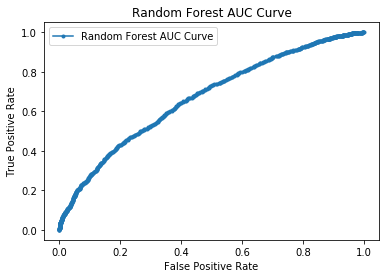

In [27]:
#Show the ROC Plot
roc_score_plot(clf,X_test,y_test,'Random Forest AUC Curve')

Trying a random forest model with default settings, it appears there is quite a bit of variance in the folds when examining the ALL AUC Scores section. Let's try a RandomSearchCV to optimize our parameters and see if that improves performance.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(z) for z in np.linspace(start = 200, stop = 2000, num = 5)]
#number of features at every split
max_features = ['auto','sqrt']

#max depth
max_depth = [int(z) for z in np.linspace(100, 500, num = 5)]
max_depth.append(None)
#create random grid
random_grid = {
'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth
}
#Random search of parameters
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
            n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1)
#Fit the model
clf_random.fit(X_train, y_train)
#print results
print(clf_random.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.5min finished


{'n_estimators': 1550, 'max_features': 'auto', 'max_depth': 200}


In [29]:
#Random Forest with optimal parameters
clf_1 = RandomForestClassifier(n_jobs=2, n_estimators = 1550, max_features='auto',random_state=0,max_depth = 200)
clf_1.fit(X_train, y_train)
clf_1predict = clf_1.predict(X_test)

In [30]:
#Random Forest results after using optimal parameters
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
clf_1_cv_score = cross_val_score(clf_1, X_train, y_train, cv=5)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, clf_1predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, clf_1predict))
print('\n')
print("=== All AUC Scores ===")
print(clf_1_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", clf_1_cv_score.mean())

=== Confusion Matrix ===
[[ 905  826]
 [ 635 1570]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.59      0.52      0.55      1731
         1.0       0.66      0.71      0.68      2205

    accuracy                           0.63      3936
   macro avg       0.62      0.62      0.62      3936
weighted avg       0.63      0.63      0.63      3936



=== All AUC Scores ===
[0.63099397 0.61880559 0.62388818 0.61022872 0.62420584]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6216244603579201


ROC AUC= 0.6708641014657355


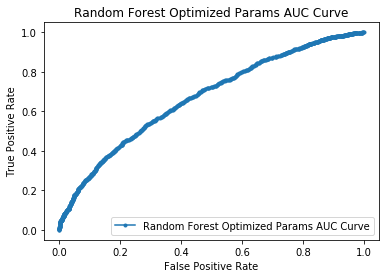

In [31]:
#Show the ROC Plot
roc_score_plot(clf_1,X_test,y_test,'Random Forest Optimized Params AUC Curve')

As you can see, the folds are fairly close together in the AUC Scores and our mean AUC Score went up about 5%. This model with optimal parameters is definitely an improvement over the first iteration.

In [32]:
#Stochastic Gradient Descent (SGD) Model
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(penalty="l2", max_iter=1000)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [33]:
#Stochastic Gradient Descent (SGD) Results
from sklearn import metrics
from sklearn.metrics import roc_auc_score
y_train_pred = clf.predict(X_train)
print (metrics.roc_auc_score(y_test, predictions))


0.5246096589993595


SGD Model receives a score of 0.524, which is about 0.1 lower than the Random Forest achieved.

In [34]:
#Tensorflow Model
import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop



In [35]:
#Prep the data for tensorflow model
from sklearn import preprocessing

#Normalize
x = data_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_df = pd.DataFrame(x_scaled)
x = scaled_df.drop(len(scaled_df.columns)-1,axis=1)
#Test and Train
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.2)
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
y_train = y_train.reshape(15741,1)
#Check Shape
print('X_train shape is {} and y_train shape is {}.'.format(X_train.shape,y_train.shape))


X_train shape is (15741, 124) and y_train shape is (15741, 1).


In [36]:
#Build the model using a learning rate of 0.0008. 
#This was selected as an optimal value via trial and error.
adam = tf.optimizers.Adam(0.0008)

def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu',input_shape=(102,1)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])
    
             
    model.compile(optimizer=adam,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC()])
    return model

In [37]:
#Run the model
model = get_compiled_model()
model.fit(X_train,y_train,epochs=8)


Train on 15741 samples
Epoch 1/8
15741/15741 [==============================] - 4s 228us/sample - loss: 0.6839 - auc: 0.5647
Epoch 2/8
15741/15741 [==============================] - 2s 130us/sample - loss: 0.6772 - auc: 0.5975
Epoch 3/8
15741/15741 [==============================] - 2s 134us/sample - loss: 0.6743 - auc: 0.6072
Epoch 4/8
15741/15741 [==============================] - 2s 134us/sample - loss: 0.6736 - auc: 0.6098
Epoch 5/8
15741/15741 [==============================] - 2s 132us/sample - loss: 0.6729 - auc: 0.6097
Epoch 6/8
15741/15741 [==============================] - 2s 137us/sample - loss: 0.6726 - auc: 0.6121
Epoch 7/8
15741/15741 [==============================] - 2s 137us/sample - loss: 0.6720 - auc: 0.6147
Epoch 8/8
15741/15741 [==============================] - 2s 136us/sample - loss: 0.6718 - auc: 0.6146


In [45]:
from sklearn.metrics import roc_curve, auc
predict_NN = model.predict(X_test)
predict_NN = predict_NN[:,0]
nn_auc = roc_auc_score(y_test, predict_NN)
print('AUC Score of Neural Net is {}'.format(lr_auc))

AUC Score of Neural Net is 0.6204136467294362


After evaluating each model, the Random Forest Model after performing a Random Search to locate optimal parameters was the best model in this scenario. I believe that the size of the data set (22,000 rows) hindered the performance of the Tensorflow NN, and given a much larger dataset it would eventually outperform the RF. 

Companies are spending countless dollars and employee hours trying to predict stock performance, and maybe attempting to build a model that could do this at a high rate on a laptop was a bit naive. However, I believe the RF accuracy of about 63% could still be very valuable to the average trader that doesn't have access to large computing power, and could be used as a way to alert a trader to potential buys that would be worth looking into. In production a person could imput the selected features in the model that are freely available online and then use it as a starting point for stocks they would like to research further. Maintaining the model would be relatively easy to do, all you would need to do is gather the input data each year when the 